In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GRU,LSTM
from tensorflow.keras.models import Model
import keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#!pip install tensorflow-gpu==2.3

In [ ]:
uploaded=files.upload()

Saving prepared_data.csv to prepared_data.csv


In [ ]:
data=pd.read_csv('prepared_data.csv')
data.head()

,SMS_TEXT,ENGLISH_TEXT
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [ ]:
def preprocessing_steps(data):
    """Applying the length on both sms_text and english_text and filtering the sentences based on length 
    adding start token and end token for inputs and output dataframe
    \t-> start token which represents start of the sentence
    \n-> end token which represents end of the sentence.
    Removing the sms_length, english_length, and ENGLISH_TEXT and appending ENGLISH_INPUT,ENGLISH_OUTPUT for the decoder."""
    data['sms_length']=data['SMS_TEXT'].apply(len)
    data['eng_length']=data['ENGLISH_TEXT'].apply(len)
    data=data[data['sms_length']<=170]
    data=data[data['eng_length']<=200]
    data['ENGLISH_INPUT']='\t '+data['ENGLISH_TEXT'].astype(str)
    data['ENGLISH_OUTPUT']=data['ENGLISH_TEXT'].astype(str)+' \n'
    data=data.drop(['sms_length','eng_length','ENGLISH_TEXT'],axis=1)
    return data



In [ ]:
preprocessed_data=preprocessing_steps(data)
print(preprocessed_data.shape)
preprocessed_data.iloc[0]['ENGLISH_INPUT']=str(preprocessed_data.iloc[0]['ENGLISH_INPUT'])+' \n'
preprocessed_data.iloc[0]['ENGLISH_OUTPUT']=str(preprocessed_data.iloc[0]['ENGLISH_OUTPUT'])+' \n'

(1993, 3)


In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data= train_test_split(preprocessed_data,test_size=0.01, random_state=42)
print(train_data.shape)
print(test_data.shape)

(1973, 3)
(20, 3)


In [ ]:
def preparing_data_for_model(preprocessed_data):
    """1. Creating input and output characters list.
       2. Creating input and output vocabluary list
       3. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       4. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       5. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       6. Return input_token_index,output_token_index,encoder_input_data,decoder_output_data,decoder_input_data.
    """
    #creating vocabluary.
    input_charcters_list=sorted(list(set(preprocessed_data['SMS_TEXT'].apply(list).sum())))
    output_charcters_list=sorted(list(set(preprocessed_data['ENGLISH_INPUT'].apply(list).sum())))
    input_token_index = dict((c, i) for i, c in enumerate(input_charcters_list))   
    output_token_index=dict((c, i) for i, c in enumerate(output_charcters_list))
    print(len(input_token_index))
    print(len(output_token_index))
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),170,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].values)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,input_token_index[char]]=1
        encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].values)):
        for t,char in enumerate(output_text):
            decoder_input_data[i,t,output_token_index[char]]=1
            if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
               decoder_output_data[i, t - 1, output_token_index[char]] = 1
        decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return input_token_index,output_token_index,encoder_input_data,decoder_input_data,decoder_output_data  

In [ ]:
def preparing_val_data_for_model(preprocessed_data,input_token_index,output_token_index):
    """1. Getting the arguments as data,input token vocabulary and output token vocabulary.
       2. Initialising np.array with zeros for encoder_input_data,decoder_input_data and decoder_output_data.
       3. One hot encoding of encoder_input_data,decoder_input_data and decoder_output_data.
       4. Decoder_output_data would be one time step ahead of decoder_input_data which is known as teacher enforcing.
       5. Return encoder_input_data,decoder_output_data,decoder_input_data.
    """
    
   
    #intialising np.array with zeros for one hot encoding.
    encoder_input_data = np.zeros((len(preprocessed_data),170,len(input_token_index)), dtype="int32")
    decoder_input_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    decoder_output_data = np.zeros((len(preprocessed_data),202,len(output_token_index)), dtype="int32")
    #one hot encoding of encoder input data
    for i,input_text in enumerate(list(preprocessed_data['SMS_TEXT'].values)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,input_token_index[char]]=1
        encoder_input_data[i,t+1,input_token_index[" "]]=1   
    #one hot encoding of decoder input data and decoder output data   
    for i,output_text in enumerate(list(preprocessed_data['ENGLISH_INPUT'].values)):
        for t,char in enumerate(output_text):
            decoder_input_data[i,t,output_token_index[char]]=1
            if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
               decoder_output_data[i, t - 1, output_token_index[char]] = 1
        decoder_input_data[i, t + 1 :, output_token_index[" "]] = 1
        decoder_output_data[i, t:, output_token_index[" "]] = 1   
    return encoder_input_data,decoder_input_data,decoder_output_data  

In [ ]:
#for trained data
input_token_index,output_token_index,encoder_input_data,decoder_input_data,decoder_output_data=preparing_data_for_model(train_data)
#for validation data
cv_encoder_input_data,cv_decoder_input_data,cv_decoder_output_data=preparing_val_data_for_model(test_data,input_token_index,output_token_index)

103
92


<h2> GRU </h2>

In [ ]:
tf.keras.backend.clear_session()
encoder_inputs = tf.keras.Input(shape=(None,len(input_token_index)))
encoder = tf.keras.layers.GRU(100, return_state=True)
encoder_outputs,state_h= encoder(encoder_inputs)
#storing encoder states
encoder_states = state_h
 
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = tf.keras.Input(shape=(None, len(output_token_index)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = tf.keras.layers.GRU(100, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(len(output_token_index), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
 
# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 103)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 100), (None, 61500       input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, None, 100),  58200       input_2[0][0]                    
                                                                 gru[0][1]                    

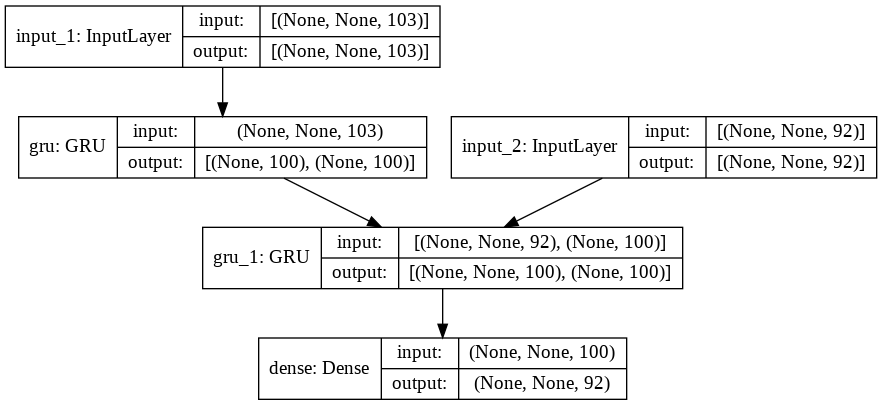

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

<h3>Training GRU model for 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 35s 57ms/step - loss: 4.3960 - val_loss: 4.2950
Epoch 2/260
31/31 [==============================] - 1s 27ms/step - loss: 4.2349 - val_loss: 4.0985
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 3.9942 - val_loss: 3.6156
Epoch 4/260
31/31 [==============================] - 1s 27ms/step - loss: 3.0955 - val_loss: 1.8410
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 1.6462 - val_loss: 1.7022
Epoch 6/260
31/31 [==============================] - 1s 27ms/step - loss: 1.5482 - val_loss: 1.6097
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 1.4849 - val_loss: 1.5465
Epoch 8/260
31/31 [==============================] - 1s 28ms/step - loss: 1.4083 - val_loss: 1.5009
Epoch 9/260
31/31 [==============================] - 1s 27ms/step - loss: 1.3482 - val_loss: 1.4687
Epoch 10/260
31/31 [==============================] - 1s 27ms/step - loss: 1.3538 - val_loss: 1.445

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 4s 50ms/step - loss: 0.6996 - val_loss: 0.7622
Epoch 2/260
31/31 [==============================] - 1s 27ms/step - loss: 0.7056 - val_loss: 0.7612
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 0.7010 - val_loss: 0.7602
Epoch 4/260
31/31 [==============================] - 1s 27ms/step - loss: 0.6909 - val_loss: 0.7590
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 0.7154 - val_loss: 0.7583
Epoch 6/260
31/31 [==============================] - 1s 27ms/step - loss: 0.7101 - val_loss: 0.7575
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 0.6987 - val_loss: 0.7564
Epoch 8/260
31/31 [==============================] - 1s 28ms/step - loss: 0.7134 - val_loss: 0.7552
Epoch 9/260
31/31 [==============================] - 1s 27ms/step - loss: 0.6954 - val_loss: 0.7543
Epoch 10/260
31/31 [==============================] - 1s 27ms/step - loss: 0.6859 - val_loss: 0.7531

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 4s 51ms/step - loss: 0.5780 - val_loss: 0.6210
Epoch 2/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5724 - val_loss: 0.6205
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5736 - val_loss: 0.6201
Epoch 4/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5709 - val_loss: 0.6199
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5774 - val_loss: 0.6197
Epoch 6/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5801 - val_loss: 0.6191
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5639 - val_loss: 0.6193
Epoch 8/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5731 - val_loss: 0.6187
Epoch 9/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5725 - val_loss: 0.6185
Epoch 10/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5594 - val_loss: 0.6183

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 4s 51ms/step - loss: 0.5137 - val_loss: 0.5757
Epoch 2/260
31/31 [==============================] - 1s 28ms/step - loss: 0.5316 - val_loss: 0.5757
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5176 - val_loss: 0.5756
Epoch 4/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5201 - val_loss: 0.5755
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5186 - val_loss: 0.5753
Epoch 6/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5114 - val_loss: 0.5749
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5101 - val_loss: 0.5752
Epoch 8/260
31/31 [==============================] - 1s 28ms/step - loss: 0.5187 - val_loss: 0.5747
Epoch 9/260
31/31 [==============================] - 1s 28ms/step - loss: 0.5183 - val_loss: 0.5749
Epoch 10/260
31/31 [==============================] - 1s 27ms/step - loss: 0.5106 - val_loss: 0.5749

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 5s 51ms/step - loss: 0.4891 - val_loss: 0.5665
Epoch 2/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4928 - val_loss: 0.5665
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4927 - val_loss: 0.5669
Epoch 4/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4864 - val_loss: 0.5665
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4859 - val_loss: 0.5663
Epoch 6/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4879 - val_loss: 0.5662
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4956 - val_loss: 0.5661
Epoch 8/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4926 - val_loss: 0.5655
Epoch 9/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4951 - val_loss: 0.5661
Epoch 10/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4919 - val_loss: 0.5661

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 4s 52ms/step - loss: 0.4851 - val_loss: 0.5648
Epoch 2/260
31/31 [==============================] - 1s 28ms/step - loss: 0.5010 - val_loss: 0.5654
Epoch 3/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4765 - val_loss: 0.5650
Epoch 4/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4851 - val_loss: 0.5652
Epoch 5/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4851 - val_loss: 0.5656
Epoch 6/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4804 - val_loss: 0.5651
Epoch 7/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4766 - val_loss: 0.5651
Epoch 8/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4801 - val_loss: 0.5647
Epoch 9/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4792 - val_loss: 0.5652
Epoch 10/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4792 - val_loss: 0.5650

<h3> Training GRU for another 260 epochs </h3>

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=260,callbacks=[rl])

Epoch 1/260
31/31 [==============================] - 4s 52ms/step - loss: 0.4667 - val_loss: 0.5649
Epoch 2/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4882 - val_loss: 0.5649
Epoch 3/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4778 - val_loss: 0.5642
Epoch 4/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4641 - val_loss: 0.5647
Epoch 5/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4797 - val_loss: 0.5653
Epoch 6/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4826 - val_loss: 0.5648
Epoch 7/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4821 - val_loss: 0.5647
Epoch 8/260
31/31 [==============================] - 1s 27ms/step - loss: 0.4885 - val_loss: 0.5651
Epoch 9/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4783 - val_loss: 0.5653
Epoch 10/260
31/31 [==============================] - 1s 28ms/step - loss: 0.4654 - val_loss: 0.5650

In [ ]:
model.save('my_model_0.5647.h5') 

In [ ]:
model = tf.keras.models.load_model('/content/my_model_0.5647.h5')

<h3> Model Predicition </h3>

In [ ]:
int_2_char_input=dict((i, char) for char, i in input_token_index.items())
int_2_char_output=dict((i,char) for char, i in output_token_index.items())
print(int_2_char_input)
print(int_2_char_output)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '<', 29: '=', 30: '>', 31: '?', 32: '@', 33: 'A', 34: 'B', 35: 'C', 36: 'D', 37: 'E', 38: 'F', 39: 'G', 40: 'H', 41: 'I', 42: 'J', 43: 'K', 44: 'L', 45: 'M', 46: 'N', 47: 'O', 48: 'P', 49: 'Q', 50: 'R', 51: 'S', 52: 'T', 53: 'U', 54: 'V', 55: 'W', 56: 'X', 57: 'Y', 58: 'Z', 59: '^', 60: '_', 61: 'a', 62: 'b', 63: 'c', 64: 'd', 65: 'e', 66: 'f', 67: 'g', 68: 'h', 69: 'i', 70: 'j', 71: 'k', 72: 'l', 73: 'm', 74: 'n', 75: 'o', 76: 'p', 77: 'q', 78: 'r', 79: 's', 80: 't', 81: 'u', 82: 'v', 83: 'w', 84: 'x', 85: 'y', 86: 'z', 87: '£', 88: 'É', 89: 'Ñ', 90: 'Ü', 91: 'à', 92: 'ä', 93: 'å', 94: 'è', 95: 'é', 96: 'ì', 97: 'ñ', 98: 'ò', 99: 'ö', 100: 'ø', 101: 'ù', 102: 'ü'}
{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: '#', 6: '$', 7: '%', 8: '&', 9: "

In [ ]:

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc = model.layers[2].output  # gru
encoder_states = state_h_enc
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 103)]       0         
_________________________________________________________________
gru (GRU)                    [(None, 100), (None, 100) 61500     
Total params: 61,500
Trainable params: 61,500
Non-trainable params: 0
_________________________________________________________________


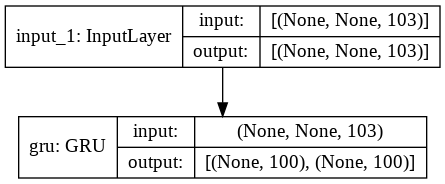

In [ ]:
tf.keras.utils.plot_model(encoder_model, show_shapes=True)

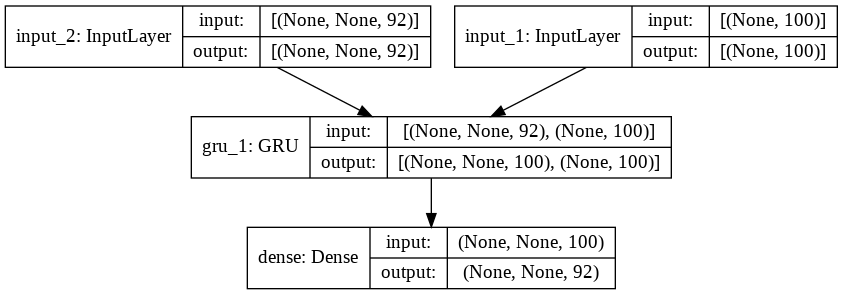

In [ ]:

decoder_inputs=model.inputs[1]
decoder_state_input_h = tf.keras.Input(shape=(100,))
decoder_outputs, state_h_dec= model.layers[3](decoder_inputs, initial_state=decoder_state_input_h)
decoder_model = tf.keras.Model([decoder_inputs,decoder_state_input_h],decoder_outputs)
decoder_states =state_h_dec
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model((decoder_inputs,decoder_state_input_h),(decoder_outputs,decoder_states))
tf.keras.utils.plot_model(decoder_model, show_shapes=True)

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             58200       input_2[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 92)     9292        gru_1[2][0]                

In [ ]:
def predictions(input_seq):
    #print(np.argmax(input_seq))
    states=encoder_model(input_seq)
    target_seq = np.zeros((1, 1, 92))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_index["\t"]] = 1
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
        
        output_tokens,states= decoder_model((target_seq,states))
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_index]
        if (sampled_char == '\n' or len(decoded_sentence) > 202):
            stop_condition = True
            return decoded_sentence
        
        decoded_sentence += sampled_char
        target_seq = np.zeros((1, 1, 92))
        target_seq[0, 0, sampled_token_index] = 1
    
    return decoded_sentence    


In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_SENTENCE")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_encoder_input_data[seq:seq+1]
    print("Prediction")
    print(predictions(input_seq))
    print()
    

English_SENTENCE
Yeah. That day I checked, did not have. So how? Where do you want? 

Prediction
 Yes. I am still and stay and then we are at home.                                                                                                                                                         

English_SENTENCE
I think you can, just get the address from your friends first. Haha, I did a lot of shopping. Felt quite bad, because Aust shop a lot already. 

Prediction
 I think I want to go to the place to see you tomorrow.                                                                                                                                                    

English_SENTENCE
Oh, want to go there? 

Prediction
 Oh. I am having to chat to go to the exam see you.                                                                                                                                                        

English_SENTENCE
Are you driving there tomorrow? 

Prediction
 

In [ ]:
model.evaluate([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data)

1/1 [==============================] - 1s 592ms/step - loss: 0.5647


0.564670741558075

<h2> LSTM </h2>

In [ ]:
tf.keras.backend.clear_session()
encoder_inputs = tf.keras.Input(shape=(None,len(input_token_index)))
encoder = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs,state_h,state_c= encoder(encoder_inputs)
#storing encoder states
encoder_states = [state_h,state_c]
 
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = tf.keras.Input(shape=(None, len(output_token_index)))
 
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder_gru(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(len(output_token_index), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
 
# Define the model
model2 = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 103)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 81600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  77200       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [ ]:
#model with 1% validation data with Adam optimizer.
optimizer = tf.keras.optimizers.Adam(0.01)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy')
model2.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=64,epochs=30,callbacks=[rl])

Epoch 1/30
31/31 [==============================] - 4s 61ms/step - loss: 2.5045 - val_loss: 1.6449
Epoch 2/30
31/31 [==============================] - 1s 39ms/step - loss: 1.4840 - val_loss: 1.2629
Epoch 3/30
31/31 [==============================] - 1s 39ms/step - loss: 1.1281 - val_loss: 1.1174
Epoch 4/30
31/31 [==============================] - 1s 38ms/step - loss: 0.9828 - val_loss: 0.9829
Epoch 5/30
31/31 [==============================] - 1s 38ms/step - loss: 0.8631 - val_loss: 0.9053
Epoch 6/30
31/31 [==============================] - 1s 38ms/step - loss: 0.7890 - val_loss: 0.8511
Epoch 7/30
31/31 [==============================] - 1s 38ms/step - loss: 0.7631 - val_loss: 0.8059
Epoch 8/30
31/31 [==============================] - 1s 38ms/step - loss: 0.7299 - val_loss: 0.7654
Epoch 9/30
31/31 [==============================] - 1s 38ms/step - loss: 0.7120 - val_loss: 0.7320
Epoch 10/30
31/31 [==============================] - 1s 38ms/step - loss: 0.6652 - val_loss: 0.7028
Epoch 11/

In [ ]:
model2.save('lstm_model_0.5566.h5') 

<h3> Model Prediciton </h3>

In [ ]:

encoder_inputs = model2.input[0]  # input_1
encoder_outputs, state_h_enc,state_c_enc = model2.layers[2].output  # gru
encoder_states = [state_h_enc,state_c_enc]
encoder_model2 = tf.keras.Model(encoder_inputs, encoder_states)

encoder_model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 103)]       0         
_________________________________________________________________
lstm (LSTM)                  [(None, 100), (None, 100) 81600     
Total params: 81,600
Trainable params: 81,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:

decoder_inputs=model2.inputs[1]
decoder_state_input_h= tf.keras.Input(shape=(100,))
decoder_state_input_c= tf.keras.Input(shape=(100,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm =model2.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model2.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 100),  77200       input_2[0][0]                    
                                                                 input_5[0][0]              

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model2.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 92))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, output_token_index["\t"]] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        
        output_tokens,hidden_states,cell_states= decoder_model([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_char = int_2_char_output[sampled_token_index]
        if (sampled_char == '\n' or len(decoded_sentence) > 202):
            stop_condition = True
            return decoded_sentence
        
        decoded_sentence += sampled_char
        target_seq = np.zeros((1, 1, 92))
        target_seq[0, 0, sampled_token_index] = 1
        states_value = [hidden_states, cell_states]
    return decoded_sentence    

In [ ]:
for seq in range(len(test_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    print("English_SENTENCE")
    print(test_data['ENGLISH_OUTPUT'].iloc[seq])
    input_seq = cv_encoder_input_data[seq:seq+1]
    print("Prediction")
    print(decode_sequence(input_seq))
    print()

English_SENTENCE
Yeah. That day I checked, did not have. So how? Where do you want? 

Prediction
 Yes. I am not in the paster the bus still got to buy what time the place to the tomorrow we go to school to see you.                                                                                      

English_SENTENCE
I think you can, just get the address from your friends first. Haha, I did a lot of shopping. Felt quite bad, because Aust shop a lot already. 

Prediction
 I am still go to see you all can go to school.                                                                                                                                                            

English_SENTENCE
Oh, want to go there? 

Prediction
 Oh, I will be late of and the place to the tomorrow.                                                                                                                                                      

English_SENTENCE
Are you driving there tomorrow? 

Prediction
 

In [ ]:
model2 = tf.keras.models.load_model('/content/lstm_model_0.5566.h5')

In [ ]:
model2.evaluate([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data)

1/1 [==============================] - 1s 576ms/step - loss: 0.5556


0.5555940866470337